# Notebook #2: Investigation on Item Popularity

This notebook will outline a short study of item popularity in recommender systems. 


## Setup the working environment for this notebook

In [51]:
import sys 
import os

sys.path.append(os.path.join('..'))

In [52]:
import pandas as pd
import numpy as np

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
from helpers.utils import *

In [55]:
data_path = '../data/'

## Data analysis: item popularity in the dataset

First, we load the Movielens 1M dataset. 

In [56]:
dataset = 'ml1m'
smode = 'utime'

In [57]:
data =  pd.read_csv('../data/outputs/splits/' + dataset + '_' + method + '.csv', encoding='utf8')

We assume that the number of ratings is a proxy of the popularity of the item. We calculate the popularity of each item and we sort items in a dataframe by decreasing popularity. 

In [8]:
item_pop = data.groupby([item_field]).count().sort_values(user_field, ascending=False)[user_field]

In [58]:
item_pop.head()

item_id
2651    3428
253     2991
1106    2990
1120    2883
466     2672
Name: user_id, dtype: int64

For the sake of easiness, we conduct our study focusing on two sets of items: most popular items and less popular items. To this end, we will consider the most popular 800 items in the first set, while the remaining items are included in the second set. Several ways to split items in these two sets arefound in literature (e.g., most popular items that receive the 80% of the overall ratings).    

In [59]:
head_tail_split = 808
head_tail_items = np.array(item_pop[:head_tail_split].index)
long_tail_items = np.array(item_pop[head_tail_split:].index)

In [60]:
print('Head Tail', compute_gini(item_pop[:head_tail_split]))
print('Long Tail', compute_gini(item_pop[head_tail_split:]))

Head Tail 0.2746823308765163
Long Tail 0.5250342105989467


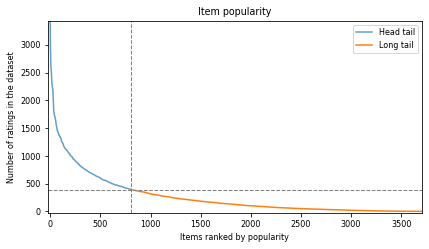

In [10]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(6, 3.5))

plt.title(r'Item popularity')
plt.xlabel('Items ranked by popularity')
plt.ylabel('Number of ratings in the dataset')
plt.plot(range(head_tail_split), item_pop.values[:head_tail_split], alpha=0.7, label=r'Head tail')
plt.plot(range(head_tail_split, len(item_pop.index)), item_pop.values[head_tail_split:], label=r'Long tail')
plt.axhline(y=item_pop.values[head_tail_split], linestyle='--', lw=1, c='grey')
plt.axvline(x=head_tail_split, linestyle='--', lw=1, c='grey')
plt.xlim([-25, len(item_pop.index)])
plt.ylim([-25, item_pop.values[0]])
plt.legend()
plt.tight_layout()

Please note how the curve is skewed towards items with only few ratings. In our case, most popular items are those receving more than 450 ratings. In the rest of this study, we will investigate how recommendation algorithms treat items belonging to these sets. 

## Data analysis: popularity of the recommended items

We will use the same cutoffs we have configured in the first notebook. 

**IMPORTANT BOOKMARK** Please bookmark this point. 

In [115]:
cutoffs = np.array([5, 10, 20, 50, 100, 200])

In this notebook, we will first compare the characteristics of the items recommended by pairwise, pointwise, random and mostpop strategies. Later on, we will come back here to compare also the results of the mitigation procedures with those of the above recommendation algorithms.  

In [116]:
model_types = ['utime_pairwise', 'utime_pointwise', 'utime_random', 'utime_mostpop']

To speed up, we will load the metrics pre-computed in the first notebook. 

In [117]:
metrics = {}
for model_type in model_types:
    metrics[model_type] = load_obj(os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + model_type + '_metrics.h5'))

First, we will compare the considered algorithms based on their recommendation effectiveness: precision, recall, and NDCG. 

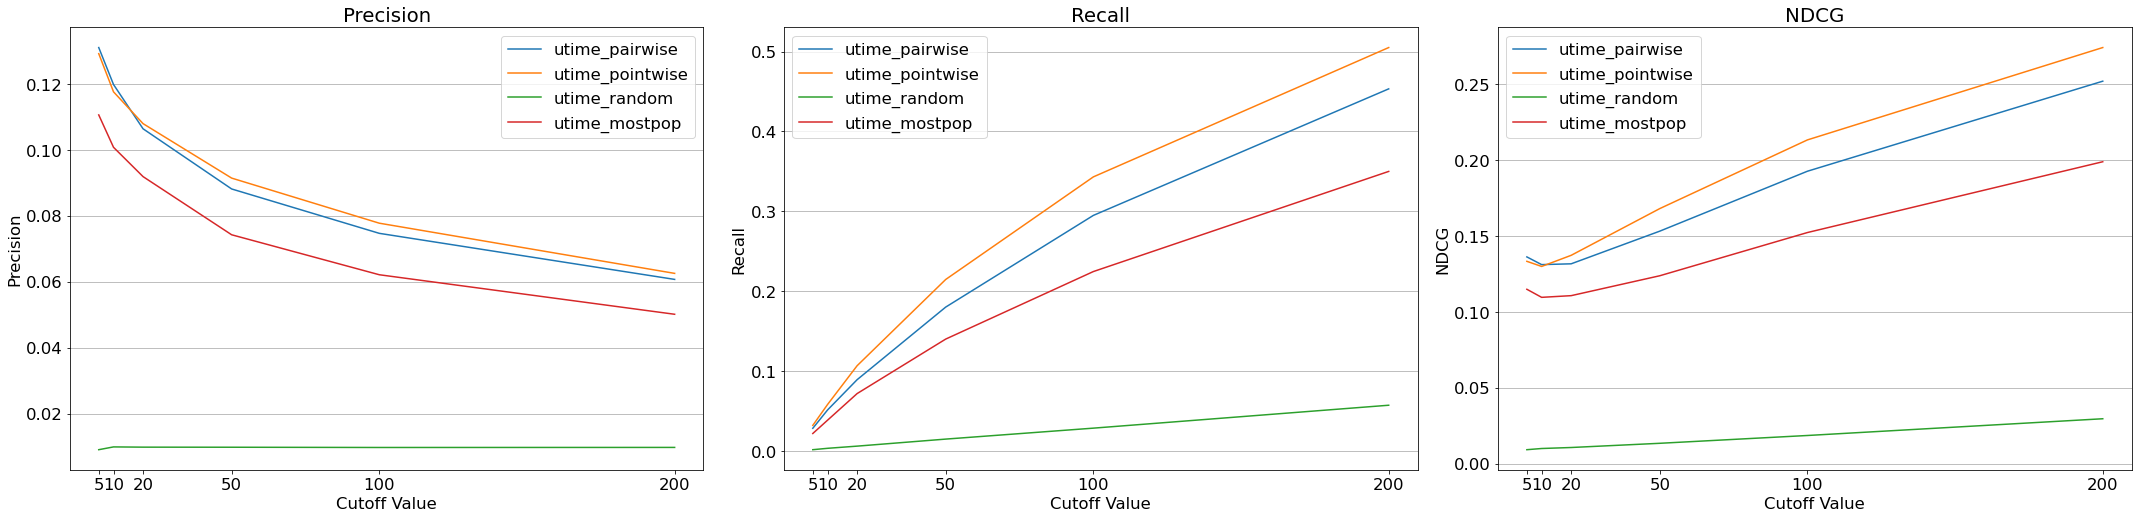

In [118]:
plt.rcParams.update({'font.size': 16.5})
plt.figure(figsize=(30, 7.5))

plt.subplot(131)
plt.title(r'Precision')
plt.xlabel('Cutoff Value')
plt.ylabel('Precision')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['precision'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.subplot(132)
plt.title(r'Recall')
plt.xlabel('Cutoff Value')
plt.ylabel('Recall')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['recall'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.subplot(133)
plt.title(r'NDCG')
plt.xlabel('Cutoff Value')
plt.ylabel('NDCG')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['ndcg'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.xticks(cutoffs)
plt.legend()
plt.grid(axis='y')

plt.tight_layout()

Please note that pairwise and mostpop algorithms have a really similar behavior for all the considered metrics. Nove, we move our attention to the popularity of the recommended items and the coverage of the items we marked as "less popular".  

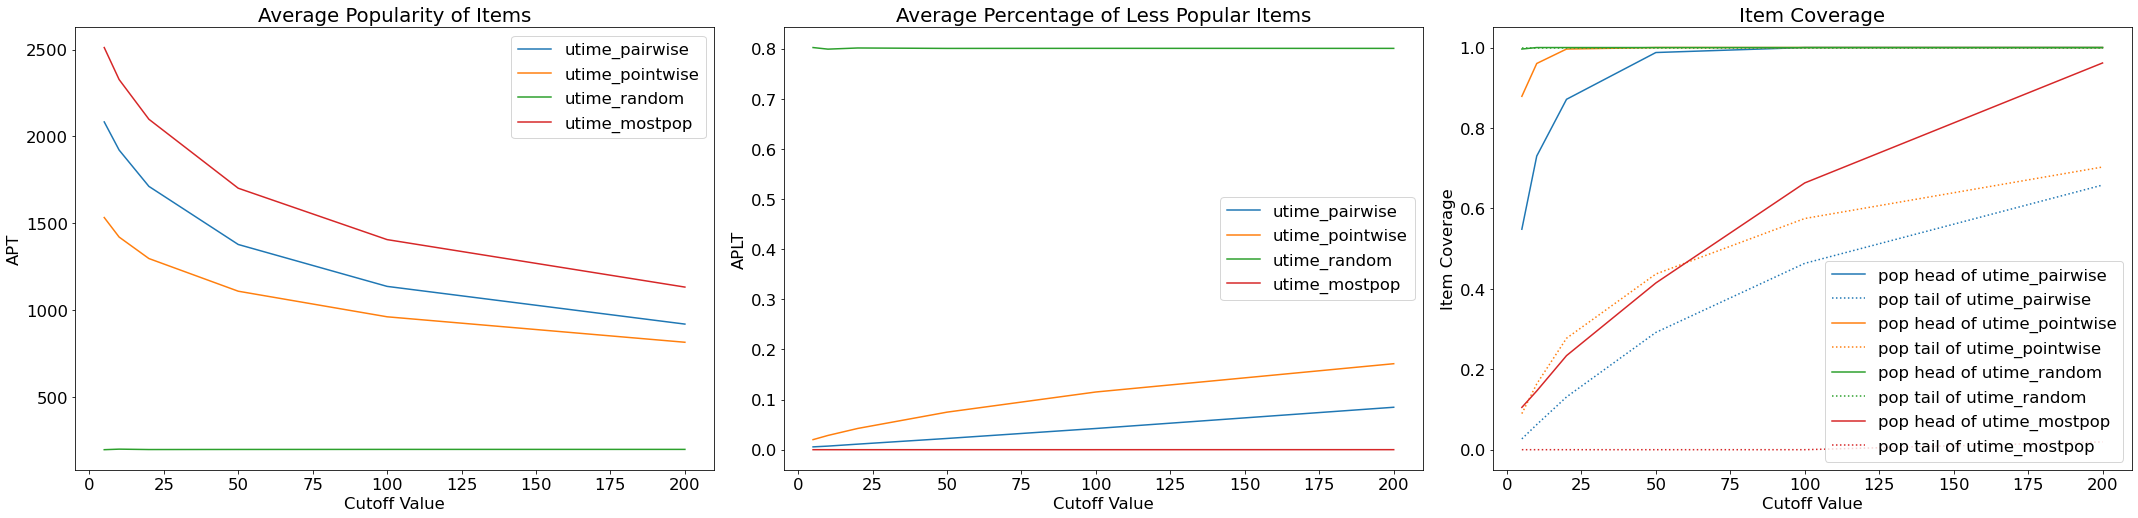

In [119]:
plt.rcParams.update({'font.size': 16.5})
plt.figure(figsize=(30, 7.5))

plt.subplot(131)
plt.title(r'Average Popularity of Items')
plt.xlabel('Cutoff Value')
plt.ylabel('APT')
for model_type in model_types:
    plt.plot(cutoffs, [np.mean(metrics[model_type]['mean_popularity'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.legend()

plt.subplot(132)
plt.title(r'Average Percentage of Less Popular Items')
plt.xlabel('Cutoff Value')
plt.ylabel('APLT')
for model_type in model_types:
    plt.plot(cutoffs, [np.sum(metrics[model_type]['item_coverage'][k,long_tail_items]) / np.sum(metrics[model_type]['item_coverage'][k,:]) for k in range(len(cutoffs))], label=model_type)
plt.legend()

plt.subplot(133)
plt.title(r'Item Coverage')
plt.xlabel('Cutoff Value')
plt.ylabel('Item Coverage')
for i, model_type in enumerate(model_types):
    plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,head_tail_items] if m > 0]) / len(head_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle='-', label='pop head of ' + model_type)
    plt.plot(cutoffs, [len([1 for m in metrics[model_type]['item_coverage'][k,long_tail_items] if m > 0]) / len(long_tail_items) for k in range(len(cutoffs))], color='C'+str(i), linestyle=':', label='pop tail of ' + model_type)
plt.legend()

plt.tight_layout()

These figures show us that the average popularity of items recommended by the pairwise algorithm is really high and not so far from the one of items recommended by mostpop. This observation is also confirmed by the coverage of items from the "less popular" set. For small cutoffs, pairwise and mostpop recommened only a tiny fraction of the less popular items. 

## Sample treatment to promote less popular items: post-processing

In this part, we will show how to setup and perform a post-processing mitigation approach. We show a didactic version of the xQuad algorithm adaptation proposed by Adbollahpouri et al. (2018). A model able to perform a re-ranking of the items has the same structure of the models we considered so far. Therefore, we first need to prepare all the data needed to initialize a model, as done in the first notebook. 

In [79]:
traintest = pd.read_csv('../data/outputs/splits/' + dataset + '_' + smode + '.csv', encoding='utf8')

In [80]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

In [81]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [82]:
items_metadata = traintest.drop_duplicates(subset=['item_id'], keep='first')
category_per_item = items_metadata[type_field].values

Now, we are ready to import and usethe re-ranking model mentioned above. 

In [83]:
from models.ranker_xquad import RankerXQuad
model = RankerXQuad(users, items, train, test, category_per_item, item_field, user_field, rating_field)

> Initializing user, item, and categories lists
> Initializing observed, unobserved, and predicted relevance scores
> Initializing item popularity lists
> Initializing category per item
> Initializing category preference per user
> Initializing metrics


In [84]:
original_model_type = 'utime_pairwise' # This string identifies the recommendation algorithm where the re-ranking is applied
reranked_model_type = original_model_type + '_' + 'xquad' # This string is an identifier for models results in data/outputs

We initialize the model predictions with those of the original recommendation model, precomputed in the first notebook. 

In [85]:
predictions = load_obj(os.path.join(data_path,'outputs/predictions/' + dataset + '_' + original_model_type + '_scores.pkl'))

In [86]:
model.set_predictions(predictions)

Now, we can run the re-ranking process and save the positional relevance of items for users after re-ranking.  

In [ ]:
model.rerank(type='smooth', lmbda=0.4, k=10, rmax=100, head_tail_split=head_tail_split)

In [94]:
predictions = model.get_predictions()

In [95]:
save_obj(predictions, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + reranked_model_type + '_scores.pkl'))

Finally, we compute and show the metrics for the recommender systems obtained after re-ranking. 

In [96]:
model.test(cutoffs)

> Making metrics for user 6000 / 6040

In [ ]:
metrics = model.get_metrics()

In [34]:
save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + reranked_model_type + '_metrics.h5'))

**To speed up**

This re-ranking takes several minutes. For this tutorial, please feel free to stop and load directly our pre-computed re-ranking predictions (2 MB).  

In [ ]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1lAmSPd19F4WRfWz0TOdFcOzHUMieSJOX'}) 
downloaded.GetContentFile('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl')      

In [93]:
model.set_metrics(load_obj('../data/outputs/metrics/ml1m_utime_pairwise_xquad_metrics.pkl')) 

In [37]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

 Precision: 0.1205 
 Recall: 0.0292 
 NDCG: 0.1247 
 Hit Rate: 0.3894 
 Avg Popularity: 1333.8445 
 Category Diversity: 0.2066 
 Novelty: 2.5279 
 Item Coverage: 0.27 
 User Coverage: 0.3894


Finally, we have obtained the metrics resulting from the considered strategy. Now, we come back to the **IMPORTANT BOOKMARK** mentioned above, using cutoffs = np.array([5, 10]) and adding 'utime_pairwise_xquad' to the model_types list. Then, we can rerun all the cells for plotting in order to compare the results obtained with these strategy against the ones of the baseline recommendation algorithms. 

## How to extend the toolbox with mitigation strategies

- Strategy at dataset level: just apply your mitigation strategy to the original csv of the dataset and swap it in our code. 
- Strategy at train instance level: just create another generator in helpers/instances_creator.py and use it in our code.
- Strategy at learning level: create a copy of the model you want to consider for your strategy (e.g., models/pairwise.py) and add your mitigation strategy. 
- Strategy at ranking level: create a copy of the ranker mentioned above (i.e., models/ranker_xquad) and use it as a basis for another re-ranking strategy.  